## PA4 - Multiclass Learning

In this exercise you are required to design, implement, train, and test multiclass learning algorithms for the [MNIST](http://yann.lecun.com/exdb/mnist) dataset of images and the [20 Newsgroups](http://qwone.com/~jason/20Newsgroups) dataset of text news data. You will explore two different approaches to multiclass learning: *Cross Entropy*, a general loss appropriate for multiple classes, and *One-vs-All*, a reduction scheme from binary classification.

In [1]:
# Make sure to have the packages numpy, scikit-learn, and Tensorflow
# installed before starting the assignment

import time
# import numpy first
import numpy as np

## The Losses

In the case of Cross Entropy, denoted in short as **CE**, the supervision for an example $\mathbf{x}\in\mathbb{R}^d$  is, instead of a label
$y\in[k]\stackrel{\tiny \mathsf{def}}{=}\{1,\ldots,k\}$, a vector $\mathbf{y}\in\Delta^k$ where
$$\Delta^k = \big\{\mathbf{p}=(p_1,\ldots,p_k)\, \big| \, \sum_i p_i = 1
   \mbox{ and } \forall i: p_i \geq 0 \big\} ~.$$
$\Delta^k$ is called the k$^{th}$ dimensional simplex and, informally speaking, it consists of all probability vectors in $\mathbb{R}^k$. The CE loss for a target probability vector $\mathbf{y}$ and predicted probability vector $\mathbf{\hat{y}}$ is defined as follows,
   $$\ell_{CE}(\mathbf{y, \hat{y}}) \stackrel{\tiny \mathsf{def}}{=}
     \sum_{i=1}^k y[i] \log\left(\frac{y[i]}{\hat{y}[i]}\right) ~ .$$
We use the convention that $0\log(0)\stackrel{\tiny \mathsf{def}}{=} 0$. To obtain the vector $\mathbf{\hat{y}}$ we exponentiate the vector of predictions $\mathbf{z} = W\mathbf{x} \in \mathbb{R}^k$ where $\mathbf{\hat{y}}[i] = \frac{\exp({\mathbf{z}[i]})}{Z}$ for all $i \in [k]$ and $Z$ ensures that $\mathbf{\hat{y}}\in \Delta^k $.

The One-vs-All, or **OvA**, approach instead uses $k$ logistic binary classifiers: the idea is to pick the label that has been *most confidently* chosen for the given example versus the rest. Formally, the loss can be expressed as follows. Given $(\mathbf{x},y)\in\mathbb{R}^d\times[k]$ let us define $\mathbf{\bar{y}}\in\{-1,1\}^k$ as the vector of labels resulting from the multiclass reduction. That is, $\mathbf{\bar{y}}[y]=1$ and for all $j\neq y$ we set $\mathbf{\bar{y}}[j]=-1$. Then the loss for $(\mathbf{x},y)$, with $\mathbf{z}$ defined as before, is
$$
\ell_{OvA}(\mathbf{\bar{y}}, \mathbf{z}) = \sum_{j=1}^k \log\big(1+ e^{-\mathbf{\bar{y}}[j] \, \mathbf{z}[j]}\big) ~ .
$$

### ACT 1
Compute the value of $Z$ explicitly.
$$
Z
=
\sum_{i=1}^k
\exp({\mathbf{z}[i]})
$$

To propose a method of computing $\mathbf{\hat{y}}$ from $\mathbf{z}$ that is numerically stable, we should consider the scenarios where $\mathbf{z}[i]<<0$ and $\mathbf{z}[i]>>0$, which would result in underflow and overflow respectively when doing the exponentiation.

From the properties suggested on slide 19 on Multiclass Classification, we can recall that to ensure a numerically stable calculation:

$$
\mathbf{P}[i | \mathbf{x}]
= 
\frac
{\exp(\mathbf{z}[i] - z_{\hat{y}})}
{\sum_{i=1}^k
\exp(\mathbf{z}[i] - z_{\hat{y}})}
$$

Where: 

$$
z_{\hat{y}} = \max_{i}^k(\mathbf{z})
$$

Therefore, defining $\tilde{\mathbf{z}}[i] = \mathbf{z}[i] - z_{\hat{y}} $, we can stably compute $\mathbf{\hat{y}}$ as follows:

$$
\tilde{Z}
=
\sum_{i=1}^k
\exp({\tilde{\mathbf{z}}[i]})
$$

$$
\mathbf{\hat{y}}[i] = \frac{\exp({\tilde{\mathbf{z}}[i]})}{\tilde{Z}}
$$

In [2]:
def calculate_Z(z):
    """
    """
    return np.sum(np.exp(z))

def calculate_y_hat(z):
    """
    """
    # z = bound_z(z)
    Z = calculate_Z(z)
    y = np.exp(z)
    return y / Z

def bound_z(z, axis=None):
    """
    """
    c = np.amax(z, axis=axis)
    print('c', c)
    return z - np.amax(z, axis=axis)    


# testing ACT 1
z = np.random.rand(1, 5)
z = z * 1000

print(z.shape)
print('z', z)

print()
z_bound = bound_z(z)
print('bound z', z_bound)

print('exp(bound z)', np.exp(z_bound))

z = z_bound

print()
y_hat = calculate_y_hat(z)
print('y_hat', y_hat)

print('sum y_hat', np.sum(y_hat))

(1, 5)
z [[181.88324603 487.97420046 448.33118203 153.25539398 821.85248853]]

c 821.8524885339014
bound z [[-639.96924251 -333.87828808 -373.5213065  -668.59709455    0.        ]]
exp(bound z) [[1.16115285e-278 9.96556350e-146 6.05003256e-163 4.28520122e-291
  1.00000000e+000]]

y_hat [[1.16115285e-278 9.96556350e-146 6.05003256e-163 4.28520122e-291
  1.00000000e+000]]
sum y_hat 1.0


Let $X \in \mathbb{R}^{n \times d}$ be the given dataset and $\mathbf{y} \in [k]^n$ the corresponding labels. Construct one-hot vectors for each label to have a probability vector from $\Delta^k$: the one-hot vector for the class $c \in [k]$ if defined as $\mathbf{1}_c \in \Delta^k$ which is a vector of zeros except for coordinate $c$ where it is $1$. For example, suppose $k=4$ and $c=2$, then $\mathbf{1}_c$ is $(0, 1, 0, 0)$. When needed we will
be smoothing the one-hot vectors for numerical purposes. The $\epsilon$-smoothed one-hot vector for class $c$ is given by $(1-\epsilon) \mathbf{1}_c + \epsilon \mathbf{\frac1k}$ where $\mathbf{\frac1k} \in \Delta^k$ is the uniform probability vector, namely $\mathbf{\frac1k} = (\frac1k, \frac1k, \ldots, \frac1k)$.

ACT 2: Implement the `one_hot` function that given $\mathbf{y} \in [k]^n$ data of labels returns $Y \in \mathbb{R}^{n \times k}$ matrix of one-hot vectors. **In the code, the labels $\mathbf{y}$ are $0$-indexed, so you need to adjust accordingly.**

In [3]:
# Given y vector of labels, return matrix Y whose i-th row is the one-hot vector of label y_i 
# If eps is not 0, then need to compute the smoothed one-hot vectors instead
# If k is 0, then need to infer its value instead
def one_hot(y, k=0, eps=0):
    """
    ACT 2
    """
    n, _ = y.shape  # assuming y has shape (n x 1)
    
    if not k:
        k = np.amax(y)  + 1
    
    Y = np.zeros((n, k))
    col_indices = y[:, 0]
    Y[np.arange(n), col_indices] = 1.0
    
    if eps:
        Y = (1 - eps) * Y + (eps * 1 / k)
    return Y


# testing y hot
y_test = np.random.randint(0, 5, size=(10, 1))
print(y_test)
print(y_test.shape)

y_hot = one_hot(y_test)
y_hot.shape

print(y_hot)

y_hot = one_hot(y_test, eps=1e-6)
print(y_hot)

[[0]
 [4]
 [3]
 [1]
 [3]
 [3]
 [4]
 [3]
 [3]
 [0]]
(10, 1)
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]]
[[9.999992e-01 2.000000e-07 2.000000e-07 2.000000e-07 2.000000e-07]
 [2.000000e-07 2.000000e-07 2.000000e-07 2.000000e-07 9.999992e-01]
 [2.000000e-07 2.000000e-07 2.000000e-07 9.999992e-01 2.000000e-07]
 [2.000000e-07 9.999992e-01 2.000000e-07 2.000000e-07 2.000000e-07]
 [2.000000e-07 2.000000e-07 2.000000e-07 9.999992e-01 2.000000e-07]
 [2.000000e-07 2.000000e-07 2.000000e-07 9.999992e-01 2.000000e-07]
 [2.000000e-07 2.000000e-07 2.000000e-07 2.000000e-07 9.999992e-01]
 [2.000000e-07 2.000000e-07 2.000000e-07 9.999992e-01 2.000000e-07]
 [2.000000e-07 2.000000e-07 2.000000e-07 9.999992e-01 2.000000e-07]
 [9.999992e-01 2.000000e-07 2.000000e-07 2.000000e-07 2.000000e-07]]


You will first implement an abstract class for losses in general that has all the methods implemented except computing the loss value and the gradient. Then each of CE and OvA classes will implement their specific loss functions, and gradients separately. *Feel free to add your own methods to the class skeletons provided.*

It is worth to note that label prediction in both cases is done by predicting the coordinate with the largest value in the vector $\mathbf{z}$ as the label. In order to prevent the parameters from blowing up during training, we will implement methods `RowNorms` and `Project` to compute the norms of the rows of $W \in \mathbb{R}^{k \times d}$ and their projections onto the sphere of radius $r$.

ACT 3: Given a vector $\mathbf{v} \in \mathbb{R}^d$, compute its projection onto the sphere $S_r = \{ \mathbf{u} \in \mathbb{R}^d \, : \, \| \mathbf{u} \| \leq r \}$.

### ACT 3

The projection of $\mathbf{v}$ onto the sphere $S_r$ of radius $r$ would be given by:

$$
\mathbf{v}_{proj}
=
r
\frac
{\mathbf{v}}
{||\mathbf{v}||}
$$

In [4]:
class GenericLoss:
    def __init__(self, name="", dims = [], W0 = []):
        self.name = name
        assert dims != [] or W0 != [], 'Must set dims or W0'
        if W0 == []:
            # self.W = np.zeros(dims) + 0.5
            self.W = np.zeros(dims)
        else:
            self.W = W0
        self.k, self.d = self.W.shape
    
    # set the parameter matrix to the given W
    def Set(self, W):
        """
        ACT 4
        """
        self.W = W
    
    # get the parameter matrix of the instance
    def Get(self):
        """
        ACT 5
        """
        return self.W
    
    # update the parameter matrix by adding given dW
    def Update(self, dW):
        """
        ACT 6
        """
        self.W += dW  # assuming matrix shapes are compatible
    
    # compute the norms of the rows of the parameter matrix
    def RowNorms(self):
        """
        ACT 7
        """
        return self.norm_rows(self.W)
    
    # compute the projection of each of the rows to the sphere of radius rad
    def Project(self, rad):
        """
        ACT 8
        """
        scale = rad / self.RowNorms()
        scale[scale > 1.0] = 1.0  # TO-DO: scale > 1 or scale > rad?
        self.W *= scale
    
    # compute the numerical predictions (z values) given a data matrix X
    def Predict(self, X):
        """
        ACT 9

        Returns
        -------
        Z : np.array(n x k)
            A matrix of predictions Z.
        """
        scores = np.einsum('ij,kj->ki', self.W, X)
        return scores
    
    # compute the label predictions given a data matrix X
    def PredictLabels(self, X):
        """
        ACT 10
        
        Returns
        -------
        labels : np.array(1 x n)
            A vector with the argmax of matrix Z, over all rows.
        """
        labels = np.argmax(self.Predict(X), axis=1)  # or axis 1?
        labels = labels.reshape((-1, 1))
        return labels
    
    # compute the classification error given a data matrix X, and label vector y
    def Error(self, X, y):
        """
        ACT 11
        
        Error is the sum of all missed predictions. For each one of them, +1.
        
        Returns
        -------
        e : scalar
            The cumulative error.
        """
        # y = y.reshape((1, -1))
        labels = self.PredictLabels(X)
        # e = (y != labels).astype(int)
        e = (y != labels)
        return np.sum(e) / labels.size
        
    @staticmethod
    def norm_rows(A):
        """
        Returns
        -------
        norm : np.array(1 x dim_b)
        """
        return np.linalg.norm(A, axis=1, keepdims=True)  # TO-DO: what shape should this be?

    def normalize_rows(self, A):
        """
        Normalizes the rows of a matrix.
        
        Returns
        -------
        B : np.array
            Normalized copy of A.
        """
        norm = self.norm_rows(A)
        if np.amax(norm) == 0.0:
            print('equal')
            return A
        return A / norm

    def Loss(self, X, y):
        pass
    
    def Gradient(self, X, y):
        pass

To implement the specific losses, you simply need to compute the loss value itself given $X \in \mathbb{R}^{n \times d}, \mathbf{y} \in [k]^n$ and the parameter matrix $W \in \mathbb{R}^{k \times d}$ as well as the gradient of that loss with respect to $W$. Let us first express $\ell^{\mathsf{CE}}$ and $\ell^{\mathsf{OvA}}$ in terms of $X, \mathbf{y}, W$.

$$\ell^{\mathsf{CE}}(X, \mathbf{y}, W) = \frac{1}{n} \sum_{i=1}^n \ell_{CE}(\mathbf{y}_i, \hat{\mathbf{y}}_i), \quad \ell^{\mathsf{OvA}}(X, \mathbf{y}, W) = \frac{1}{n} \sum_{i=1}^n \ell_{OvA}(\bar{\mathbf{y}}_i, \mathbf{z}_i) ~ .$$

where for each $i \in [n]$ the vectors $\mathbf{y}_i$ are the rows of $Y =$ `one_hot`$(\mathbf{y}) \in \mathbb{R}^{n \times k}$, $\bar{\mathbf{y}}_i$ are the rows of $\bar{Y} = (2Y - 1) \in \mathbb{R}^{n \times k}$, $\mathbf{z}_i$ are the rows of $\mathbf{Z} = X W^{\top} \in \mathbb{R}^{n \times d}$, and $\hat{\mathbf{y}}_i = \exp(\mathbf{z}_i)/Z_i$ with $Z_i$ making sure $\hat{\mathbf{y}}_i \in \Delta^k$. The gradient computation can be done step-by-step using the chain rule.

ACT 12: Compute the gradient of $\ell^{\mathsf{CE}}$ w.r.t. $W$, given by $\nabla_W \ell^{\mathsf{CE}}$.

Hint: First, show for a single $\mathbf{y}, \mathbf{\hat{y}}, \mathbf{z}$ that $\nabla_{\mathbf{z}} \ell_{CE}(\mathbf{y}, \mathbf{\hat{y}}) = \mathbf{\hat{y}} - \mathbf{y}$ (simplify the loss function explicitly in terms of $\mathbf{z}$ to make things easier). Afterwards, denoting $\hat{Y} \in \mathbb{R}^{n \times k}$ the matrix with rows $\mathbf{\hat{y}}_i$ for all $i \in [n]$, conclude that $\nabla_W \ell^{\mathsf{CE}}(X, \mathbf{y}, W) = \frac1n (\hat{Y} - Y)^{\top} X$.

ACT 13: Compute the gradient of $\ell^{\mathsf{OvA}}$ w.r.t. $W$, given by $\nabla_W \ell^{\mathsf{OvA}}$.

Hint: First, show for a single $\mathbf{\bar{y}}, \mathbf{z}$ that $\nabla_{\mathbf{z}} \ell_{OvA}(\mathbf{\hat{y}}, \mathbf{z}) = - \frac{\mathbf{\hat{y}}}{1 + \exp(\mathbf{\hat{y}} \mathbf{z})}$ with all the operations in this expression being elementwise. Afterwards, conclude that $\nabla_W \ell^{\mathsf{OvA}}(X, \mathbf{y}, W) = - \frac1n \left( \frac{\bar{Y}}{1 + \exp(\bar{Y} \mathbf{Z})} \right)^{\top} X$ again operations like multiplication, exponential division being elementwise.

### ACT 12
Let's recall that:

$$
\ell_{CE}(\mathbf{z}, \mathbf{y}) 
=
\sum_{i=1}^k y_i\log(\frac{y_i}{\hat{y}_1})
= 
\sum_{i=1}^k y_i\log(\frac{Z y_i}{e^{z_i}})
$$

We split the equation using the natural logarithm properties:

$$
\ell_{CE}(\mathbf{z}, \mathbf{y}) 
=
\sum_{i=1}^k y_i (\log(Z))
+
\sum_{i=1}^k y_i (\log(y_i))
-
\sum_{i=1}^k y_i (\log(e^{z_i}))
$$

Calculating the derivative w.r.t. to $z_i$:

$$
\frac{d\ell_{CE}}{dz_{i}}
=
\frac{e^{z_i}}{Z}
+
0
-
y_i
=
\hat{y}_i - y_i
$$

Which implies that, in the matrix form:

$$
\frac{d \ell(Y, Z)}{dZ}
=
\hat{Y} - Y
$$

Next we compute the derivative of $Z$ w.r.t. $W$.

$$
\frac{dZ}{dW}
=
X
$$

Putting all together with the chain rule, and matching the dimensions of the matrices:
$$
\nabla_W \ell^{\mathsf{CE}}(X, \mathbf{y}, W) = \frac1n (\hat{Y} - Y)^{\top} X
$$



### ACT 13

First, we compute the gradient for a single example  ($\mathbf{\bar{y}}, \mathbf{z}$). Let's recall that:

$$
\ell_{OvA}(\mathbf{\bar{y}}, \mathbf{z}) = \log(1+ e^{-\mathbf{\bar{y}} \mathbf{z}})
$$

We rewrite the equations:

$$
\ell(\mathbf{u}) =  \log(\mathbf{u})
$$
$$
\mathbf{u} =  \log(1+ e^{-\mathbf{\bar{y}} \mathbf{z}})
$$

We find their derivative w.r.t. $\mathbf{z}$ using the chain rule.

$$
\frac{d \ell(\mathbf{u})}{d\mathbf{u}}
=
\frac{1}{\mathbf{u}}
$$

$$
\frac{d \mathbf{u}}{d\mathbf{z}}
=
-\mathbf{\bar{y}} e^{-\mathbf{\bar{y}} \mathbf{z}}
$$

Multiplying:
$$
\frac{d \ell(\mathbf{u})}{d\mathbf{z}}
=
\frac{d \ell(\mathbf{u})}{d\mathbf{u}}
\frac{d \mathbf{u}}{d\mathbf{z}}
=
\frac{-\mathbf{\bar{y}} e^{-\mathbf{\bar{y}} \mathbf{z}}} {1+ e^{-\mathbf{\bar{y}} \mathbf{z}}}
=
\frac{-\mathbf{\bar{y}}} {1+ e^{\mathbf{\bar{y}} \mathbf{z}}}
$$

Which implies that, for the matrix form:
$$
\frac{d \ell(\bar{Y}, Z)}{dZ}
=
\frac{-\bar{Y}} {1+ e^{\bar{Y}Z}}
$$

Next we compute the derivative of $Z$ w.r.t. $W$.

$$
\frac{dZ}{dW}
=
X
$$

Putting all together and matching the matrices dimensions:
$$
\nabla_W \ell^{\mathsf{OvA}}(X, \mathbf{y}, W)
=
- \frac1n \left( \frac{\bar{Y}}{1 + e^{\bar{Y} \mathbf{Z}}} \right)^{\top}X
$$


In [5]:
class CrossEntropy(GenericLoss):

    # In CE, the one-hot vectors should be smoothed with the given eps parameter.
    def __init__(self, name="CrossEntropy", dims=[], W0=[], eps=1e-6):
        super().__init__(name, dims, W0)
        self.eps = eps
    
    def Loss(self, X, y, verbose=False):
        """
        ACT 14
        Compute the cross-entropy loss.
        
        Parameters
        ----------
        X : np.array(n x d)
            The data matrix.
        y : np.array(1 x n)
            The labels vector.
            
        Returns
        -------
        loss : scalar
            The value of the cross-entropy loss.
        """
        Y = one_hot(y, k=self.k, eps=self.eps)  # n x k  
        Y_hat = self.calculate_Y_hat(X, verbose=verbose)

        loss = Y * np.log(Y / Y_hat)
        loss_ce = np.sum(loss, axis=1)     
        loss_CE = np.average(loss_ce)
        
        if verbose:
            print('total Y', np.sum(Y))
            print('total Y hat', np.sum(Y_hat))
            print('total loss', np.sum(loss))
            print('total loss ce', np.sum(loss_ce))
            print('total loss ce', np.sum(loss_CE))
        return loss_CE
    
    def Gradient(self, X, y):
        """
        ACT 15
        
        Compute the gradient of the cross-entropy loss w.r.t to W.
        
        Parameters
        ----------
        X : np.array(n x d)
            The data matrix.
        y : np.array(1 x n)
            The labels vector.
        
        Returns
        -------
        grad : np.array(k x d)
            The matrix gradient of the cross-entropy loss function.
        """
        n, d = X.shape
        Y = one_hot(y, k=self.k, eps=self.eps)  # n x k
        
        Y_hat = self.calculate_Y_hat(X)
        Y_temp = Y_hat - Y
        
        # (1 / n) * (Y_matrix - Yhat_matrix)^T * X
        grad = np.einsum('ij,ik->jk', Y_temp, X)  # k x d
        # grad = np.matmul(np.transpose(Y_temp), X)
        return  grad / n

    def calculate_Y_hat(self, X, verbose=False):
        """
        Computes the Y_hat matrix.
        
        Returns
        ------
        Y_hat : np.array(n x k)
            The Y_hat matrix.
        """
        Z = self.Predict(X)  # n x k  
        labels = self.PredictLabels(X)
        Z -= labels
    
        Y_hat_1 = np.exp(Z)  # n x k
        Z_sum = np.sum(Y_hat_1, axis=1).reshape((-1, 1))
    
        Y_hat = Y_hat_1 / Z_sum # constrain to simplex  ### check this! before commenting it, tests did not pass
        # Y_hat = Y_hat_1 / np.average(Y_hat_1, axis=0)  # constrain to simplex  ### check this! before commenting it, tests did not pass
        
        if verbose:
            print('****Inside Y hat****')
            print('Z', Z)
            print('total Z', np.sum(Z))
            print('Y hat non div', Y_hat_1)
            print('total Y hat not div', np.sum(Y_hat_1))
            
            print('Y hat div', Y_hat)
            print('total Y hat not div', np.sum(Y_hat))
            print('****Leaving Y hat****')
        return Y_hat

    
class LogisticOvA(GenericLoss):
    def __init__(self, name="LogisticOvA", dims=[], W0=[]):
        super().__init__(name, dims, W0)

    def Loss(self, X, y, verbose=False):
        """
        ACT 16
        
        Computes the one-versus-all loss. Operations are element-wise.
        
        Parameters
        ----------
        X : np.array(n x d)
            The data matrix.
        y : np.array(1 x n)
            The labels vector.
            
        Returns
        -------
        loss : scalar
            The value of the cross-entropy loss.
        """
        Y = one_hot(y, k=self.k)  # n x k
        Y_dash = self.calculate_Y_dash(Y)
        
        Z = self.Predict(X)  # n x k
        #  Z = self.normalize_rows(Z)  # TO-DO: Test with and without normalization

        power = -1 * Y_dash * Z
        loss = np.log(1 + np.exp(power))
        loss_ova = np.sum(loss, axis=1)
        loss_OVA = np.average(loss_ova)
        return loss_OVA
        
    def Gradient(self, X, y):
        """
        ACT 17
        
        Compute the gradient of the  one-versus-all loss w.r.t to W.
        
        Parameters
        ----------
        X : np.array(n x d)
            The data matrix.
        y : np.array(1 x n)
            The labels vector.
        
        Returns
        -------
        grad : np.array(k x d)
            The matrix gradient of the cross-entropy loss function.
        """
        n, d = X.shape
        Y = one_hot(y, k=self.k)  # n x k
        Y_dash = self.calculate_Y_dash(Y)
        Z = self.Predict(X)  # n x k
        #  Z = self.normalize_rows(Z)  # TO-DO: Test with and without normalization
        
        A = 1 + np.exp(Y_dash * Z)
        B = Y_dash / A
        grad =  -1 * np.einsum('ij,ik->jk', B, X) / n
        return grad
    
    def calculate_Y_dash(self, Y):
        """
        Computes the Y_dash matrix.
        
        Returns
        ------
        Y_dash : np.array(n x k)
            The Y_dash matrix.
        """
        return 2 * Y - 1.0

After implementing the two loss classes, we will test them the following way:

(i) the loss of random labels should be larger than the loss of the assigned labels (the result of `PredictLabels`);

(ii) the gradient with random labels should have a bigger norm than that with the assigned labels;

(iii) the gradient norm should decrease after a single small gradient step.

In [6]:
# assert the 3 points above for the loss class given by loss_tested
# after implementing make sure both CrossEntropy, LogisticOvA pass all tests
def TestLoss(loss_tested):
    n, d, k, tests = 100, 10, 7, 1000
    test_loss = loss_tested(W0=[], dims=(k, d))
    
    # the number of tests is given by tests.
    # for each test, generate random Gaussian matrices X, W of appropriate sizes.
    for _ in range(tests):
        X, W = np.random.randn(n, d), np.random.randn(k, d)
        test_loss.Set(W)
    
        # assert that the loss value with the assigned labels y is smaller than that
        # with labels uniformly random from the interval [0, k-1].
        y, y_rand = test_loss.PredictLabels(X), np.random.randint(0, k, n).reshape((n, -1))
        ### ACT 18: loss value on X with assigned labels y
        loss1 = test_loss.Loss(X, y)
        ### ACT 19: loss value on X with random labels y_rand
        loss2 = test_loss.Loss(X, y_rand)
        assert loss1 < loss2, "Loss test failed (%f >= %f)" % (loss1, loss2)
    
        # assert that the gradient norm with the assigned labels is smaller than that
        # with labels uniformly random from the interval [0, k-1].
        grad1 = test_loss.Gradient(X, y)
        ### ACT 20: norm of the gradient with X and assigned labels y
        norm_grad1 = np.linalg.norm(grad1, ord='fro')
        ### ACT 21: norm of the gradient with X and random labels y_rand
        grad2 = test_loss.Gradient(X, y_rand)
        norm_grad2 = np.linalg.norm(grad2, ord='fro')
        assert norm_grad1 < norm_grad2, "Gradient norm test failed (%f >= %f)" % (norm_grad1, norm_grad2)
        
        # assert that after making a single gradient step (in the opposite direction)
        # the gradient norm decreases (choose a small step size).
        test_loss.Update(-0.01 * grad1)
        grad3 = test_loss.Gradient(X, y)
        ### ACT 22: norm of the gradient with X and y after making a single gradient step
        norm_grad3 = np.linalg.norm(grad3, ord='fro')
        assert norm_grad3 < norm_grad1, "Gradient step test failed (%f >= %f)" % (norm_grad3, norm_grad1)
    
    return True

LossTested = CrossEntropy
if TestLoss(LossTested): print('CE Test Passed')

LossTested = LogisticOvA
if TestLoss(LossTested): print('Logistic OvA Test Passed')

CE Test Passed
Logistic OvA Test Passed


Below are methods from previous assignments for data processing and training. No need to reimplement these.

In [7]:
# Sample a mini-batch w/ or w/o replacement
from numpy.random import randint
from numpy.random import permutation
class IndexSampler:
    def __init__(self, d):
        self.d = d
        self.prm = None
    
    def sample_new_index(self, replace=0):
        if replace:
            return randint(self.d)
        if self.prm is None:
            self.prm = permutation(self.d)
            self.head = 0
        ind = self.prm[self.head]
        self.head += 1
        if self.head == self.d:
            self.head = 0
            self.prm = None
        return ind

In [8]:
# Create a vector of learning-rate values. Mode can be: 'fixed_t', 'linear_t', 'sqrt_t'
# Internal shift_t parameter can/should be changed during experiments.
def learning_rate_schedule(eta0, epochs, mode):
    base_t = 10.0
    if mode == 'fixed_t':
        return eta0 * np.ones(epochs)
    if mode == 'sqrt_t':
        return eta0 * np.ones(epochs) / (base_t + np.sqrt(np.arange(epochs)))
    if mode == 'linear_t':
        return eta0 * np.ones(epochs) / (base_t + np.arange(epochs))
    print('invalid mode for learning rate schedule: %s' % mode)

In [9]:
def prepare_logistic_sgd_handle(batch_size, epochs, eta0, lr_mode, rad, replace, eps=None):
    """
    Assembles parameters to train SGD algorithm.
    
    Returns
    ------
    handle : dict
        The parameters dictionary.
    """
    h = {}
    h['pstr'] = 'Epoch: {0:2d}  Loss: {1:5.3f}  Error: {2:5.3f} %'
    
    h['rad'] = rad
    h['replace'] = replace
    h['eta0'] = eta0
    
    h['epochs'] = epochs
    h['batch_size'] = batch_size
    
    h['lr_mode'] = lr_mode
    h['eps'] = eps
    return h

In [10]:
# SGD with general loss class. h is the handle defined above.
def SGD(X, y, Loss, params):
    h = params
    
    pstr, rad, replace = h['pstr'], h['rad'], ['replace']
    eta0, epochs, bs, lrmode = h['eta0'], h['epochs'], h['batch_size'], h['lr_mode']
    
    n, d = X.shape
    nbs = int(n / bs)
    k = np.amax(y) + 1
    
    ls = Loss(W0=[], dims=(k, d))
    eps = h.get('eps')
    if eps:
        ls.eps = eps
        
    eta_t = learning_rate_schedule(eta0, epochs, lrmode)
    losses = [ls.Loss(X, y, verbose=False)]
    errors = [ls.Error(X, y)]
    sampler = IndexSampler(nbs)

    print('*** Logistic Regression SGD with {} Loss Began ***\n'.format(ls.name))
    print(pstr.format(0, losses[-1], errors[-1] * 100))

    for e in range(1, epochs * nbs):
        head = sampler.sample_new_index(replace) * bs
        Xt, yt = X[head:head + bs], y[head:head + bs]
        gw = ls.Gradient(Xt, yt)
        ls.Update(-eta_t[e // nbs] * gw)
    
        if rad > 0:
            ls.Project(rad)
        
        if e % nbs == 0:
            losses.append(ls.Loss(X, y))
            errors.append(ls.Error(X, y))
        
        if (e % (nbs * 10)) == 0:
            print(pstr.format(e // nbs, losses[-1], errors[-1] * 100))

    return ls, losses, errors

In [11]:
# import matplotlib and get the mnist dataset from tensorflow.keras
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist as keras_mnist
(X_train, y_train), (X_test, y_test) = keras_mnist.load_data()

/Users/arpj/anaconda3/envs/cos324/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/arpj/anaconda3/envs/cos324/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/arpj/anaconda3/envs/cos324/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/arpj/anaconda3/envs/cos324/lib/python3.7/s

In [12]:
# normalize the data by subtracting the mean and dividing by std
def normalize(X, bias=0):
    n, d = X.shape
    m = np.mean(X, axis=1).reshape(n, 1) * np.ones((1, d))
    s = np.std(X, axis=1).reshape(n, 1) * np.ones((1, d))
    Xn = (X - m) / s
    if bias != 0:
        Xn = np.hstack((Xn, bias * np.ones((n, 1))))
    return Xn

# flatten the images into d-dimensional vectors for training
def flatten_images(X):
    s = X.shape
    n = s[0]
    d = np.prod(s[1:])
    return X.reshape(n, d)

Xtr = normalize(flatten_images(X_train), bias = 1)
Xte = normalize(flatten_images(X_test), bias = 1)

In [13]:
### ACT 23
# run SGD with CrossEntropy loss on the MNIST training data
# batch size should be 1000, sampling with no replacement
# number of epochs should be 500, sphere radius for W is 10.0
# learning rate mode is sqrt_t with eta=1.0

epochs = 500  # 500
batch_size = 1000
rad = 10.0
lr_mode = 'sqrt_t'
eta0 = 1.0
replace = False
eps = None  # 1e-6
loss_ce = CrossEntropy

start = time.time()
y_train_ce = y_train.reshape((-1, 1))
handle_ce = prepare_logistic_sgd_handle(batch_size, epochs, eta0, lr_mode, rad, replace, eps)
w_ce, loss_ce, error_ce = SGD(Xtr, y_train_ce, loss_ce, handle_ce)

print('*** Elapsed time: {} minutes ***'.format(round(((time.time() - start) / 60.0), 2)))

*** Logistic Regression SGD with CrossEntropy Loss Began ***

Epoch:  0  Loss: 2.303  Error: 90.128 %
Epoch: 10  Loss: 0.286  Error: 8.035 %
Epoch: 20  Loss: 0.271  Error: 7.580 %
Epoch: 30  Loss: 0.265  Error: 7.305 %
Epoch: 40  Loss: 0.260  Error: 7.223 %
Epoch: 50  Loss: 0.256  Error: 7.097 %
Epoch: 60  Loss: 0.255  Error: 6.983 %
Epoch: 70  Loss: 0.251  Error: 6.897 %
Epoch: 80  Loss: 0.249  Error: 6.787 %
Epoch: 90  Loss: 0.249  Error: 6.897 %
Epoch: 100  Loss: 0.246  Error: 6.785 %
Epoch: 110  Loss: 0.245  Error: 6.728 %
Epoch: 120  Loss: 0.244  Error: 6.673 %
Epoch: 130  Loss: 0.243  Error: 6.593 %
Epoch: 140  Loss: 0.242  Error: 6.632 %
Epoch: 150  Loss: 0.241  Error: 6.607 %
Epoch: 160  Loss: 0.241  Error: 6.567 %
Epoch: 170  Loss: 0.240  Error: 6.630 %
Epoch: 180  Loss: 0.239  Error: 6.553 %
Epoch: 190  Loss: 0.239  Error: 6.543 %
Epoch: 200  Loss: 0.238  Error: 6.563 %
Epoch: 210  Loss: 0.238  Error: 6.500 %
Epoch: 220  Loss: 0.237  Error: 6.517 %
Epoch: 230  Loss: 0.238  Er

In [14]:
### ACT 24
# compute test error and loss

W0 = w_ce.W
loss_ce_test = CrossEntropy(W0=W0)

y_test_ce = y_test.reshape((-1, 1))
test_loss_ce = loss_ce_test.Loss(Xte, y_test_ce)
test_err_ce = loss_ce_test.Error(Xte, y_test_ce)

msg = 'CE Test Loss: {0:5.3f}  CE Test Error: {1:5.3f} %'
print(msg.format(test_loss_ce, test_err_ce * 100))

CE Test Loss: 0.263  CE Test Error: 7.300 %


/Users/arpj/anaconda3/envs/cos324/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.
/Users/arpj/anaconda3/envs/cos324/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """


In [15]:
def plotter(fname, data_list, lnames=None):
    for data in data_list:
        plt.plot(range(1, 1 + len(data)), data, linewidth=2, linestyle='-')

    if lnames:
        plt.legend(tuple(lnames))
    
    plt.grid()    
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel(fname, fontsize=14)
    plt.show()

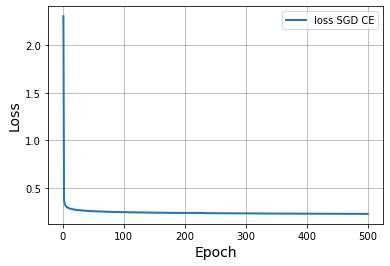

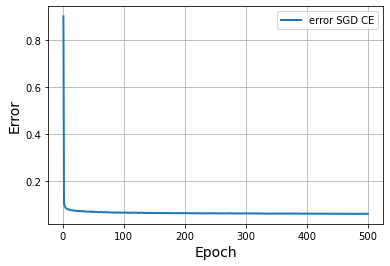

In [16]:
### ACT 25
# plot loss vs epochs, separately plot error vs epochs
plotter('Loss', [loss_ce], ['loss SGD CE'])
plotter('Error', [error_ce], ['error SGD CE'])

In [18]:
### ACT 26
# using test data construct a confusion matrix C that is 10x10
# C[i][j] indicates pct digit i was classified as j

def confusion_matrix(loss_object, X, y):
    """
    """
    Y_hat = loss_object.calculate_Y_hat(X)
    n, k = Y_hat.shape
    C = np.zeros((k, k))

    for idx in range(k):
        indices = np.nonzero(y == idx)
        rows, cols = indices
        y1 = Y_hat[rows, :]
        y1 = np.average(y1, axis=0)
        C[idx, :] = y1.round(3) * 100

    return C

C_mnist = confusion_matrix(loss_ce_test, Xte, y_test_ce)

# assert that each digit is most likely to be correctly classified
k1, k2 = C_mnist.shape 
assert np.array_equal(np.argmax(C_mnist, axis=1), np.arange(k1))

print('Confusion Matrix MNIST')
print(C_mnist)

Confusion Matrix MNIST
[[95.9  0.   0.3  0.4  0.1  1.3  0.9  0.4  0.4  0.1]
 [ 0.  96.   0.8  0.5  0.   0.2  0.3  0.2  1.9  0.1]
 [ 0.7  1.3 86.5  2.9  0.8  0.7  1.5  1.   4.2  0.5]
 [ 0.4  0.1  2.6 85.9  0.2  5.   0.3  1.2  3.2  1.1]
 [ 0.2  0.2  0.8  0.4 88.9  0.2  1.3  0.9  1.5  5.8]
 [ 1.3  0.3  0.8  4.8  1.1 82.9  1.8  0.8  5.2  1. ]
 [ 1.1  0.3  1.4  0.2  1.   2.4 92.8  0.2  0.6  0. ]
 [ 0.1  0.7  2.   1.2  0.8  0.2  0.  89.4  0.6  5. ]
 [ 0.8  1.3  1.9  3.7  1.2  5.8  1.4  1.1 80.7  2. ]
 [ 0.7  0.6  0.2  1.3  4.9  1.1  0.1  4.6  2.1 84.4]]


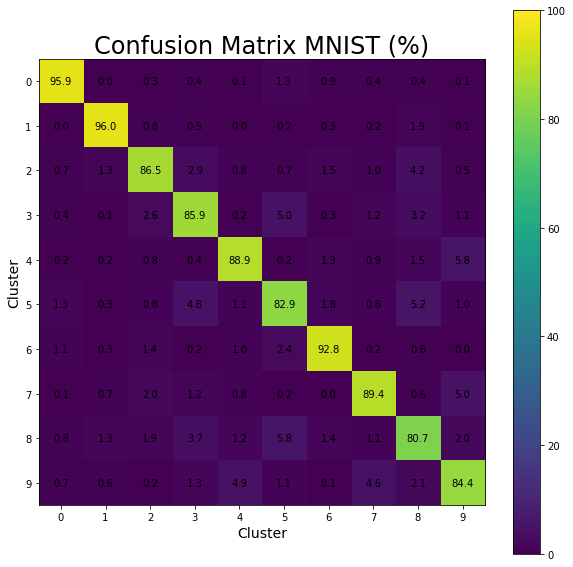

In [19]:
# plot confusion matrix
def plot_confusion_matrix(C, title=None):
    """
    """
    a, b = C.shape
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(C)
    im.set_clim(0, 100)
    ax.grid(False)

    ax.xaxis.set(ticks=list(range(a)), ticklabels=[str(x) for x in range(a)])
    ax.yaxis.set(ticks=list(range(b)), ticklabels=[str(x) for x in range(b)])

    for i in range(a):
        for j in range(b):
            ax.text(j, i, round(C[i, j], 2), ha='center', va='center', color='black', wrap=True)

    plt.xlabel('Cluster', fontsize=14)
    plt.ylabel('Cluster', fontsize=14)
    plt.title(title, fontsize=24)
    cbar = ax.figure.colorbar(im, ax=ax, format='%.0f')
    plt.show()

    
plot_confusion_matrix(C_mnist, title='Confusion Matrix MNIST (%)')

In [20]:
### ACT 27
# perform ACT 23-25 with LogisticOvA instead of CrossEntropy

epochs = 500  # 500
batch_size = 1000
rad = 10.0
lr_mode = 'sqrt_t'
eta0 = 1.0
replace = False
loss_ova = LogisticOvA

start = time.time()
y_train_ova = y_train.reshape((-1, 1))
handle_ova = prepare_logistic_sgd_handle(batch_size, epochs, eta0, lr_mode, rad, replace, eps)
w_ova, loss_ova, error_ova = SGD(Xtr, y_train_ova, loss_ova, handle_ova)

print('*** Elapsed time: {} minutes ***'.format(round(((time.time() - start) / 60.0), 2)))

*** Logistic Regression SGD with LogisticOvA Loss Began ***

Epoch:  0  Loss: 6.931  Error: 90.128 %
Epoch: 10  Loss: 0.741  Error: 9.378 %
Epoch: 20  Loss: 0.712  Error: 8.688 %
Epoch: 30  Loss: 0.695  Error: 8.547 %
Epoch: 40  Loss: 0.684  Error: 8.380 %
Epoch: 50  Loss: 0.677  Error: 8.202 %
Epoch: 60  Loss: 0.670  Error: 8.118 %
Epoch: 70  Loss: 0.664  Error: 8.058 %
Epoch: 80  Loss: 0.661  Error: 8.048 %
Epoch: 90  Loss: 0.658  Error: 7.945 %
Epoch: 100  Loss: 0.652  Error: 7.832 %
Epoch: 110  Loss: 0.648  Error: 7.897 %
Epoch: 120  Loss: 0.647  Error: 7.848 %
Epoch: 130  Loss: 0.643  Error: 7.723 %
Epoch: 140  Loss: 0.641  Error: 7.772 %
Epoch: 150  Loss: 0.638  Error: 7.750 %
Epoch: 160  Loss: 0.638  Error: 7.782 %
Epoch: 170  Loss: 0.635  Error: 7.645 %
Epoch: 180  Loss: 0.632  Error: 7.647 %
Epoch: 190  Loss: 0.631  Error: 7.577 %
Epoch: 200  Loss: 0.629  Error: 7.527 %
Epoch: 210  Loss: 0.629  Error: 7.667 %
Epoch: 220  Loss: 0.626  Error: 7.542 %
Epoch: 230  Loss: 0.625  Err

In [21]:
# Test loss OVA
W0 = w_ova.W
loss_ova_test = LogisticOvA(W0=W0)

y_test_ova = y_test.reshape((-1, 1))
test_loss_ova = loss_ova_test.Loss(Xte, y_test_ova)
test_err_ova = loss_ova_test.Error(Xte, y_test_ova)

msg = 'OVA Test Loss: {0:5.3f}  OVA Test Error: {1:5.3f} %'
print(msg.format(test_loss_ova, test_err_ova * 100))

OVA Test Loss: 0.631  OVA Test Error: 7.850 %


/Users/arpj/anaconda3/envs/cos324/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.
/Users/arpj/anaconda3/envs/cos324/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """


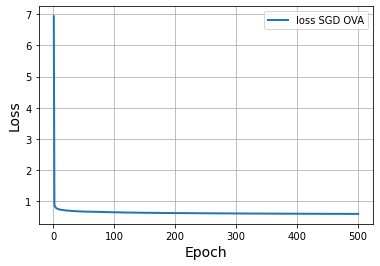

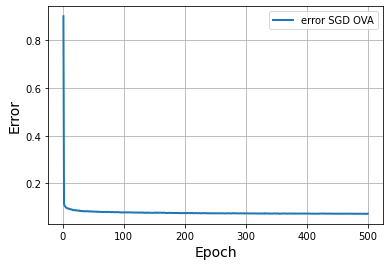

In [22]:
# plot loss OVA vs epochs, separately plot error OVA vs epochs
plotter('Loss', [loss_ova], ['loss SGD OVA'])
plotter('Error', [error_ova], ['error SGD OVA'])

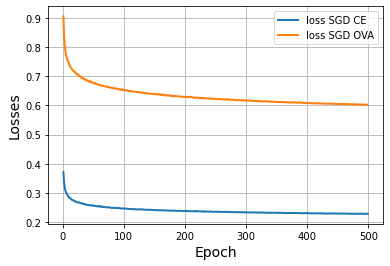

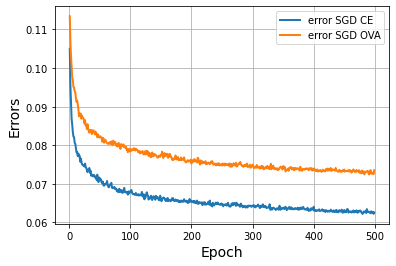

In [23]:
# compare your results, conclude in 1 sentence
# removing first loss
plotter('Losses', [loss_ce[1:], loss_ova[1:]], ['loss SGD CE', 'loss SGD OVA'])
plotter('Errors', [error_ce[1:], error_ova[1:]], ['error SGD CE', 'error SGD OVA'])

### Conclusion MNIST: Loss CE vs Loss OvA:
With the same parameters, OvA took 35% less time to compute than CE in my CPU (around 8.4 and 13.1 min respectively).
CE returns about 0.7% less error than OvA (7.2% vs. 7.9%) when classifying the X and ytest datasets, a marginal improvement.
Overall, both losses follow the same trend.

In [24]:
# data processing for 20 newsgroups datasets already done for you.
from sklearn.datasets import fetch_20newsgroups
from collections import Counter

def get_20newsgroups_data():
    newsgroups_train = fetch_20newsgroups(subset='train')
    newsgroups_test  = fetch_20newsgroups(subset='test')
    return newsgroups_train, newsgroups_test

def construct_vocabulary(data, vs):
    vocab = Counter()
    for text in data:
        for word in text.split(' '):
            vocab[word.lower()] += 1
    word2index = dict(vocab.most_common(vs))
    i = 0
    for k in word2index.keys():
        word2index[k] = i
        i += 1
    return word2index

def text_to_vec(data, vocab):
    def norm_rows(M):
        return np.sqrt(np.sum(M * M, axis=1, keepdims=True))
    def project_rows(M, r):
        return M * np.minimum(r / norm_rows(M), 1.0)
    n = len(data)
    d = len(vocab)
    X = np.zeros((n, d))
    i = 0
    for text in data:
        for word in text.split(' '):
            if word.lower() in vocab:
                X[i, vocab[word.lower()]] += 1.0
        i += 1
    # Convert to log-frequencies and normalize to have ||X[i,*]||=1
    X = project_rows(np.log(X + 1.0), 1.0)
    return X

In [25]:
vsize = 1000

train, test = get_20newsgroups_data()
vocab = construct_vocabulary(train.data, vsize)
Xtr_news = text_to_vec(train.data, vocab)
Xte_news = text_to_vec(test.data, vocab)
y_train_news = train.target
y_test_news = test.target

In [26]:
# you will perform the same experiments with this dataset
### ACT 28
# perform ACT 23-27 for the 20newsgroups dataset
# all parameters for training should be the same except:
# we will start with a much larger learning rate eta=1000.0
# and a sphere radius 40.0

handle_news_params = {
'epochs': 500,  # 500
'batch_size':1000,
'rad': 40.0,
'lr_mode': 'sqrt_t',
'eta0': 1000.0,
'replace': False,
'eps': None  # 1e-6
}

start = time.time()
loss_news_ce = CrossEntropy
y_train_news_ce = y_train_news.reshape((-1, 1))
handle_news_ce = prepare_logistic_sgd_handle(**handle_news_params)
w_news_ce, loss_news_ce, error_news_ce = SGD(Xtr_news, y_train_news_ce, loss_news_ce, handle_news_ce)

print('*** Elapsed time: {} minutes ***'.format(round(((time.time() - start) / 60.0), 2)))

*** Logistic Regression SGD with CrossEntropy Loss Began ***

Epoch:  0  Loss: 2.996  Error: 95.757 %
Epoch: 10  Loss: 1.315  Error: 31.775 %
Epoch: 20  Loss: 1.060  Error: 25.941 %
Epoch: 30  Loss: 0.951  Error: 23.042 %
Epoch: 40  Loss: 0.923  Error: 21.469 %
Epoch: 50  Loss: 0.917  Error: 20.585 %
Epoch: 60  Loss: 0.914  Error: 19.922 %
Epoch: 70  Loss: 0.914  Error: 19.710 %
Epoch: 80  Loss: 0.912  Error: 19.639 %
Epoch: 90  Loss: 0.911  Error: 19.162 %
Epoch: 100  Loss: 0.910  Error: 19.144 %
Epoch: 110  Loss: 0.910  Error: 19.153 %
Epoch: 120  Loss: 0.909  Error: 18.985 %
Epoch: 130  Loss: 0.911  Error: 19.091 %
Epoch: 140  Loss: 0.909  Error: 18.897 %
Epoch: 150  Loss: 0.910  Error: 19.038 %
Epoch: 160  Loss: 0.909  Error: 18.685 %
Epoch: 170  Loss: 0.909  Error: 18.915 %
Epoch: 180  Loss: 0.909  Error: 18.853 %
Epoch: 190  Loss: 0.909  Error: 18.738 %
Epoch: 200  Loss: 0.908  Error: 19.038 %
Epoch: 210  Loss: 0.909  Error: 18.702 %
Epoch: 220  Loss: 0.909  Error: 18.747 %
Epoch

In [27]:
# compute test error and loss

W0_news_ce = w_news_ce.W
loss_news_ce_test = CrossEntropy(W0=W0_news_ce)

y_test_news_ce = y_test_news.reshape((-1, 1))
test_loss_news_ce = loss_news_ce_test.Loss(Xte_news, y_test_news_ce)
test_err_news_ce = loss_news_ce_test.Error(Xte_news, y_test_news_ce)

msg = 'CE Test Loss: {0:5.3f}  CE Test Error: {1:5.3f} %'
print(msg.format(test_loss_news_ce, test_err_news_ce * 100))

/Users/arpj/anaconda3/envs/cos324/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.
/Users/arpj/anaconda3/envs/cos324/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """


CE Test Loss: 1.505  CE Test Error: 43.428 %


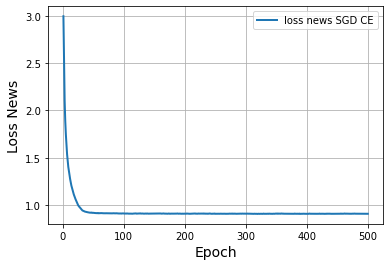

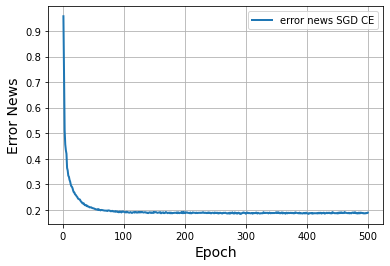

In [28]:
# plot loss vs epochs, separately plot error vs epochs
plotter('Loss News', [loss_news_ce], ['loss news SGD CE'])
plotter('Error News', [error_news_ce], ['error news SGD CE'])

In [29]:
# confusion matrix news
C_news = confusion_matrix(loss_news_ce_test, Xte_news, y_test_news_ce)

# assert that each digit is most likely to be correctly classified
k1_news, k2_news = C_news.shape
assert np.array_equal(np.argmax(C_news, axis=1), np.arange(k1_news))

print('Confusion Matrix 20Newsgroups')
print(C_news)

Confusion Matrix 20Newsgroups
[[25.   2.4  1.2  1.7  1.5  1.6  1.2  3.   3.8  3.2  1.9  2.8  2.   5.6
   4.2 13.4  3.8  4.6  5.4 11.7]
 [ 1.7 32.7  7.7  6.2  4.2  9.6  4.4  2.8  3.5  1.6  1.6  2.5  6.3  3.5
   4.2  1.7  1.5  1.5  1.4  1.3]
 [ 1.9  8.8 37.6  9.8  5.3  8.   2.9  2.3  2.7  1.7  1.2  1.8  3.1  2.8
   2.5  1.6  1.5  1.4  1.9  1.3]
 [ 1.1  7.2  7.3 33.2  9.1  4.8  5.3  4.   3.8  1.5  1.4  2.   9.1  2.7
   2.1  1.2  1.2  1.   1.   1. ]
 [ 1.3  5.7  4.4 11.9 33.6  3.6  4.5  4.8  4.4  2.2  1.8  2.1  7.   3.
   3.1  1.4  1.4  1.2  1.4  1.2]
 [ 0.9 12.1  8.   5.2  4.  41.3  3.   2.4  2.8  1.4  1.3  2.   4.3  2.5
   3.   1.7  1.2  1.1  0.9  0.9]
 [ 0.4  3.1  2.5  7.3  4.9  3.4 56.7  3.9  3.1  1.8  1.9  0.7  3.1  1.4
   1.5  1.1  1.   0.9  0.6  0.7]
 [ 2.4  3.7  2.6  3.9  4.1  2.4  3.6 32.9  8.7  3.1  2.4  1.9  6.7  4.7
   4.3  2.4  3.5  1.8  3.1  1.9]
 [ 2.7  2.9  2.   3.   2.7  2.5  2.8  8.5 39.9  3.8  2.8  2.1  4.1  4.4
   3.7  2.   3.3  1.9  3.   2. ]
 [ 4.2  2.6  1.4  1.8  1.7

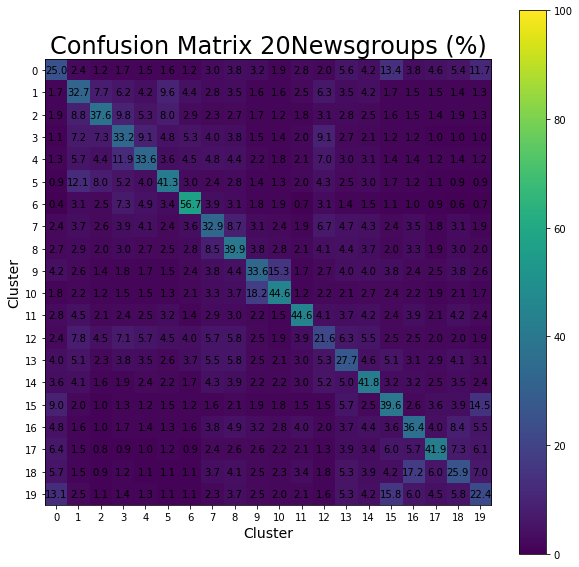

In [30]:
plot_confusion_matrix(C_news, title='Confusion Matrix 20Newsgroups (%)')

In [31]:
# Use OvA instead of CE
# all parameters for training should be the same except:
# we will start with a much larger learning rate eta=1000.0
# and a sphere radius 40.0

handle_news_params_ova = {
'epochs': 500,  # 500
'batch_size':1000,
'rad': 40.0,
'lr_mode': 'sqrt_t',
'eta0': 1000.0,
'replace': False,
'eps': None  # 1e-6
}

start = time.time()
loss_news_ova = LogisticOvA
y_train_news_ova = y_train_news.reshape((-1, 1))
handle_news_ova = prepare_logistic_sgd_handle(**handle_news_params_ova)
w_news_ova, loss_news_ova, error_news_ova = SGD(Xtr_news, y_train_news_ova, loss_news_ova, handle_news_ova)

print('*** Elapsed time: {} minutes ***'.format(round(((time.time() - start) / 60.0), 2)))

*** Logistic Regression SGD with LogisticOvA Loss Began ***

Epoch:  0  Loss: 13.863  Error: 95.757 %
Epoch: 10  Loss: 2.258  Error: 32.128 %
Epoch: 20  Loss: 1.942  Error: 26.843 %
Epoch: 30  Loss: 1.857  Error: 24.430 %
Epoch: 40  Loss: 1.841  Error: 23.413 %
Epoch: 50  Loss: 1.837  Error: 22.804 %
Epoch: 60  Loss: 1.833  Error: 22.282 %
Epoch: 70  Loss: 1.830  Error: 21.990 %
Epoch: 80  Loss: 1.829  Error: 21.929 %
Epoch: 90  Loss: 1.830  Error: 21.637 %
Epoch: 100  Loss: 1.831  Error: 21.823 %
Epoch: 110  Loss: 1.829  Error: 22.088 %
Epoch: 120  Loss: 1.827  Error: 21.619 %
Epoch: 130  Loss: 1.830  Error: 21.761 %
Epoch: 140  Loss: 1.827  Error: 21.522 %
Epoch: 150  Loss: 1.830  Error: 21.778 %
Epoch: 160  Loss: 1.831  Error: 21.831 %
Epoch: 170  Loss: 1.828  Error: 21.584 %
Epoch: 180  Loss: 1.827  Error: 21.522 %
Epoch: 190  Loss: 1.830  Error: 21.442 %
Epoch: 200  Loss: 1.829  Error: 21.531 %
Epoch: 210  Loss: 1.831  Error: 21.566 %
Epoch: 220  Loss: 1.831  Error: 21.646 %
Epoch

In [32]:
# Test loss OVA
W0_news_ova = w_news_ova.W
loss_news_ova_test = LogisticOvA(W0=W0_news_ova)

y_test_news_ova = y_test_news.reshape((-1, 1))
test_news_loss_ova = loss_news_ova_test.Loss(Xte_news, y_test_news_ova)
test_news_err_ova = loss_news_ova_test.Error(Xte_news, y_test_news_ova)

msg = 'OVA Test Loss: {0:5.3f}  OVA Test Error: {1:5.3f} %'
print(msg.format(test_news_loss_ova, test_news_err_ova * 100))

OVA Test Loss: 2.453  OVA Test Error: 43.415 %


/Users/arpj/anaconda3/envs/cos324/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.
/Users/arpj/anaconda3/envs/cos324/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """


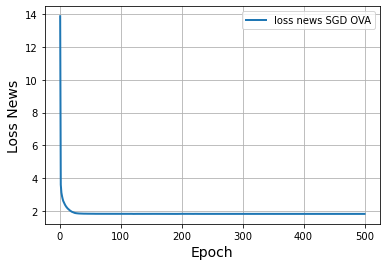

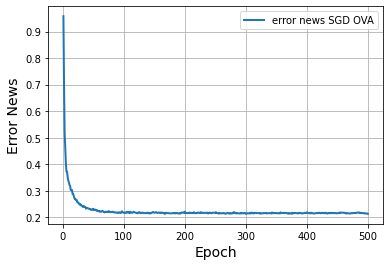

In [33]:
# plot loss vs epochs, separately plot error vs epochs
plotter('Loss News', [loss_news_ova], ['loss news SGD OVA'])
plotter('Error News', [error_news_ova], ['error news SGD OVA'])

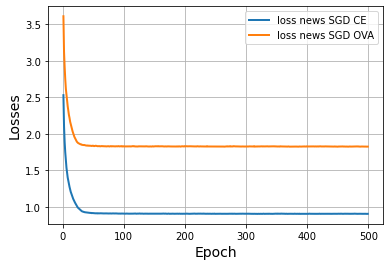

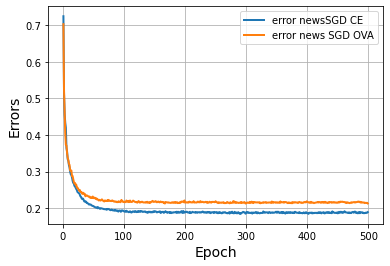

In [34]:
# compare your results, conclude in 1 sentence
# removing first loss to improve resolution
plotter('Losses', [loss_news_ce[1:], loss_news_ova[1:]], ['loss news SGD CE', 'loss news SGD OVA'])
plotter('Errors', [error_news_ce[1:], error_news_ova[1:]], ['error newsSGD CE', 'error news SGD OVA'])

### Conclusion 20NewsGroup: Loss CE vs Loss OvA:
Similar to what was mentioned in the conclusion for the MNIST dataset, with similar error value on the test data for both CE and OvA (around 43% for both), the latter method was "faster" in my machine to run for 500 iterations than the former (5.85 min vs. 3.81 min). Both losses follow once again a similar trend, with an almost constant offset in the "plateau" region.

In [68]:
### ACT 29
# after training, testing, and plotting make sure to compute the
# row norms of the final parameters (mean and std), and conclude 
# in one sentence whether the results were as you expected

# ova for the 20 news group
def compute_W_stats(LossObject):
    w_row_norms = LossObject.RowNorms()
    w_row_mean = np.mean(LossObject.W, axis=1, keepdims=True)
    w_row_std = np.std(LossObject.W, axis=1, keepdims=True)
    return np.hstack([w_row_norms, w_row_mean, w_row_std])

w_news_stats_ova = compute_W_stats(w_news_ova)
print(w_news_stats_ova)
print()
print('Mean Row Norms', np.mean(w_news_ova.RowNorms()))
print('Std Row Norms', np.std(w_news_ova.RowNorms()))

[[40.         -0.21568801  1.24638625]
 [40.         -0.21560092  1.24640132]
 [40.         -0.1754435   1.25268495]
 [40.         -0.20148907  1.24876025]
 [40.         -0.22167255  1.24533581]
 [40.         -0.18008782  1.25202571]
 [40.         -0.19151326  1.25032903]
 [40.         -0.22916012  1.24397976]
 [40.         -0.30698645  1.22709385]
 [40.         -0.20888858  1.24754381]
 [40.         -0.15968881  1.25479061]
 [40.         -0.04258666  1.26419396]
 [40.         -0.20859151  1.24759352]
 [40.         -0.25013888  1.23993167]
 [40.         -0.13902911  1.25724735]
 [40.         -0.24828515  1.24030419]
 [40.         -0.10016085  1.26093925]
 [40.         -0.1027845   1.2607281 ]
 [40.         -0.07656186  1.26259189]
 [40.         -0.14405053  1.25668192]]

Mean Row Norms 40.0
Std Row Norms 4.203627514058621e-15


In [69]:
# ova for the mnist dataset
w_mnist_stats_ova = compute_W_stats(w_ova)
print(w_mnist_stats_ova)
print()
print('Mean Row Norms', np.mean(w_ova.RowNorms()))
print('Std Row Norms', np.std(w_ova.RowNorms()))

[[ 3.85731213e+00 -1.91186874e-03  1.37660098e-01]
 [ 3.29578153e+00 -3.78319641e-04  1.17630879e-01]
 [ 3.63678573e+00 -1.63710299e-03  1.29792125e-01]
 [ 3.77680286e+00 -2.95706296e-03  1.34767437e-01]
 [ 4.13081055e+00 -1.35214799e-03  1.47428750e-01]
 [ 4.13148128e+00  5.95915624e-04  1.47457686e-01]
 [ 3.37348472e+00 -1.96783673e-03  1.20388751e-01]
 [ 3.10264331e+00 -2.68223539e-04  1.10737764e-01]
 [ 6.80149393e+00 -7.82311575e-03  2.42629640e-01]
 [ 4.51253995e+00 -3.89023095e-03  1.61012468e-01]]

Mean Row Norms 4.06191360014123
Std Row Norms 1.0001463249490132


### ACT 29

I was not expecting that norm of the rows in the LossOva for the 20Newsgroup was the same for all values of $k$, with a mean of 40 and a std of practically 0. This was particularly revealing after comparing it with the info from the LossOva for the MNIST group.